In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
# import string
# nltk.download('punkt')
# nltk.download('punkt_tab')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# import convokit
# from convokit import Corpus, download, FightingWords


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/CS329R/329RFinalProjectScripts/merged_file_sample=5000.csv")
data.head()

,subject_id,race,gender,note_id,hadm_id,note_type,note_seq,charttime,storetime,text
0,16124481,WHITE,F,16124481-DS-50,23674190,DS,50,2135-08-23 00:00:00,2135-08-23 20:34:00,\nName: ___ Unit No: ___...
1,18970086,WHITE,F,18970086-DS-71,25125143,DS,71,2156-09-06 00:00:00,2156-09-06 19:12:00,\nName: ___ Unit No: _...
2,10165018,WHITE,F,10165018-DS-15,23251005,DS,15,2132-07-07 00:00:00,2132-07-09 09:07:00,\nName: ___ Unit No: __...
3,19921471,WHITE,M,19921471-DS-33,20912515,DS,33,2153-05-30 00:00:00,2153-05-30 17:45:00,\nName: ___ Unit No: ___...
4,18946573,WHITE,M,18946573-DS-14,26825610,DS,14,2151-08-12 00:00:00,2151-08-12 07:44:00,\nName: ___ Unit No: ___...


In [3]:
def get_corpus(sample_df):
    # Sample DataFrame
    data = {
        'subject_id': [1, 2, 3],
        'race': ['A', 'B', 'A'],
        'gender': ['M', 'F', 'M'],
        'note_type': ['type1', 'type2', 'type1'],
        'note_id': [101, 102, 103],
        'note_seq': [1, 1, 2],
        'charttime': ['2022-01-01', '2022-01-02', '2022-01-03'],
        'storetime': ['2022-01-01T12:00', '2022-01-02T12:00', '2022-01-03T12:00'],
        'text': ['Note 1', 'Note 2', 'Note 3']
    }

    df = sample_df

    # Add required columns and use the index as 'id'
    df['id'] = df['note_id'].astype(str)   # Convert index to string for ConvoKit 'id'
    df['speaker'] = df['subject_id'].astype(str)  # Speaker identifier
    df['conversation_id'] = df.index.astype(str)  # Conversation ID based on note sequence
    df['reply_to'] = None   # Assuming no replies, set to None
    df['timestamp'] = pd.to_datetime(df['charttime'])  # Use 'charttime' as timestamp
    df['text'] = df['text'].astype(str)  # Convert text to string

    # Add race and gender as metadata fields for each utterance
    df['meta.race'] = df['race']
    df['meta.gender'] = df['gender']

    # Construct the utterances DataFrame with metadata columns
    utterances_df = df[['id', 'timestamp', 'text', 'speaker', 'reply_to', 'conversation_id', 'meta.race', 'meta.gender']]

    # Create the ConvoKit corpus with both utterances and speaker data
    corpus = Corpus.from_pandas(utterances_df=utterances_df)
    return corpus


# Function to extract section content
def extract_section(pattern, text):
    match = re.search(pattern, text)
    if match:
        return match.group(1).strip()
    else:
        return ""

def clean_text(text, stemm=False):
    # Tokenize text into words
    tokens = nltk.word_tokenize(text)

    # Convert tokens to lowercase
    tokens = [token.lower() for token in tokens]

    # Remove punctuation
    tokens = [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Filter out tokens that contain numbers
    tokens = [token for token in tokens if not any(char.isdigit() for char in token)]

    # # Apply stemming (optional)
    if stemm:
      stemmer = PorterStemmer()
      tokens = [stemmer.stem(token) for token in tokens]

    # Remove empty tokens
    tokens = [token for token in tokens if token]

    return tokens

def sep_sections(text):
    sections = {
        "Chief Complaint": "",
        "History of Present Illness": "",
        "Family History": "",
        "Brief Hospital Course": "",
        "Transitional Issues": "",
        "Discharge Instructions": "",
        "Followup Instructions": "",
        "Vore": ""  # Assuming "Vore" refers to a specific section that may be present
    }
    patterns = {
      "Chief Complaint": r"(?smi)^\s*Chief Complaint(?::)?\n(.*?)^\s*Major Surgical or Invasive Procedure",
      "History of Present Illness": r"(?smi)^\s*History of Present Illness(?::)?\n(.*?)^\s*Past Medical History",
      "Family History": r"(?smi)^\s*Family History(?::)?\n(.*?)^\s*Physical Exam",
      "Brief Hospital Course": r"(?smi)^\s*Brief Hospital Course(?::)?\n(.*?)^\s*TRANSITIONAL ISSUES",
      "Transitional Issues": r"(?smi)^\s*TRANSITIONAL ISSUES(?::)?\n(.*?)^\s*Medications on Admission",
      "Discharge Instructions": r"(?smi)^\s*Discharge Instructions(?::)?\n(.*?)^\s*Followup Instructions",
      "Followup Instructions": r"(?smi)^\s*Followup Instructions(?::)?\n(.*)",
    }

    for section, pattern in patterns.items():
        match = re.search(pattern, text, re.DOTALL)
        if match:
            sections[section] = match.group(1).strip()
    return sections


In [ ]:
from openai import OpenAI
import json
CLIENT = OpenAI(api_key=OPENAI_API_KEY)


def call_head(text):
  prompt = """You are a healthcare provider preparing to facilitate a goals of care conversation with a patient. Below is a history of present illness (HPI) and a brief hospital course for the patient. Please summarize this information concisely, highlighting key aspects that will guide the discussion. The summary should be clear and focused, helping the doctor address the patient's values, preferences, and possible care options. Consider the following:\n
  (1) Current medical status and prognosis: Summarize the patient's diagnosis, progression, and any ongoing treatment or interventions.\n
  (2) Functional status: Highlight any functional limitations or improvements during the hospital stay.\n
  (3) Patient's wishes: Indicate any known preferences or concerns the patient has expressed regarding treatment, quality of life, or end-of-life care.\n
  (4) Goals of care conversation points: Suggest key topics to address, such as comfort measures, life-sustaining treatments, and patient-centered goals.\n
  Your goal is to help the doctor address the patient’s preferences for future care and guide the patient through difficult decisions with empathy and clarity.\n
  """

  one_shot = """Here is an example of a discharge instruction:\n
  Dear Ms. ___,\n\n
  You were admitted for nausea, vomiting, and abdominal pain. You were evaluated by medicine doctors, gastroenterologists, and psychiatrists. As you were having difficulty with tolerating medications and food, we placed a ___ tube and started tube feeds. We also converted as many medications as we could to liquids to help you keep them down.\n\n
  Some (not all) of your medication changes are as follows:\n
  - Promethazine is now 50mg BID, do not exceed 100mg per day.\n
  - Tylenol, loperamide, ranitidine (zantac), vitamin C,\n
  lorazepam, multivitamin, melatonin are now all in liquid form\n
  - The remainder of your medications can be crushed or dissolved\n
  in water.\n
  - Protonix was changed to lansoprazole disintegrating tablet\n
  - Metoprol XL was changed to Metoprolol shorting acting BID\n
  - Trulance and Pristiq are being temporarily held until you\n
  speak to your doctors.\n\n
  You will need to follow-up with your doctors and ___ as below.\n\n
  Please take all medications as prescribed and keep all scheduled doctor's appointments. Seek medical attention if you develop a worsening or recurrence of the same symptoms that originally brought you to the hospital, experience any of the warning signs listed below, or have any other symptoms that concern you.\n\n
  It was a pleasure taking care of you!\n
  Your ___ Care Team\n
  """
  chat_completion = CLIENT.chat.completions.create(
      messages=[
          {
              "role": "user",
              "content": prompt + one_shot + "Patient Course:\n" + text,
          }
      ],
      model="gpt-3.5-turbo-0125", # the GPT model to use
      response_format={"type": "text"}
  )
  return chat_completion.choices[0].message.content

In [52]:
data = pd.read_csv("/content/drive/MyDrive/CS329R/329RFinalProjectScripts/unique_sample=5000.csv")
for idx, row in data.iterrows():
  sections = sep_sections(row["text"])
  text = " ".join([f"{key}:\n{sections[key]}\n" for key in sections if key != "Discharge Instructions" and key != "Vore"])
  output = call_head(text)
  filename = str(row["subject_id"]) + row["gender"] + "".join(x for x in row["race"] if x.isalnum()) + ".txt"
  with open(f"/content/drive/MyDrive/CS329R/329RFinalProjectScripts/GPTSummariesUniqueSet/{filename}", "w+") as outfile:
    outfile.write(output)
  if idx % 100 == 0:
    print(idx)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200


In [53]:
print(len(data))

3286


In [44]:
og_data = pd.read_csv("/content/drive/MyDrive/CS329R/329RFinalProjectScripts/merged_file_sample=5000.csv")
file_data = pd.read_csv("/content/drive/MyDrive/CS329R/329RFinalProjectScripts/generated_sample.csv")
for idx, row in og_data.iterrows():
  if row["subject_id"] not in file_data["subject_id"].values:
    print(row)
print(len(og_data))
print(len(file_data))

5000
3330


In [5]:
import os
import re
import csv
import tqdm

In [6]:
# Specify the folder containing the text files and the output CSV file path
folder_path = '/content/drive/MyDrive/CS329R/329RFinalProjectScripts/GPTSummariesSet2/'
csv_file_path = '/content/drive/MyDrive/CS329R/329RFinalProjectScripts/generated_sample_2.csv'

# Initialize a list to store data dictionaries
data = []
i = 0
# Iterate over all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        i += 1
        # Use regex to extract subject_id, gender, and race from the filename
        match = re.match(r'^(\d+)([A-Za-z])([A-Za-z0-9]+)\.txt$', filename)
        if match:
            subject_id = match.group(1)
            gender = match.group(2)
            race = match.group(3)

            # Read the contents of the text file
            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
                text_content = file.read()

            # Append the extracted data to the list
            data.append({
                'subject_id': subject_id,
                'gender': gender,
                'race': race,
                'text': text_content
            })
        else:
            print(f"Filename '{filename}' does not match the expected pattern.")
print(f"Num files: {i}")
# Specify the order of columns for the CSV
fieldnames = ['subject_id', 'gender', 'race', 'text']

# Write the data to a CSV file
with open(csv_file_path, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for row in data:
        writer.writerow(row)

print(f"Data successfully written to {csv_file_path}")


Num files: 3286
Data successfully written to /content/drive/MyDrive/CS329R/329RFinalProjectScripts/generated_sample_2.csv


In [7]:
old_data = pd.DataFrame(data)
print(old_data['race'].unique())

['BLACKAFRICANAMERICAN' 'WHITE' 'ASIANCHINESE' 'WHITEOTHEREUROPEAN'
 'WHITERUSSIAN' 'OTHER' 'BLACKCAPEVERDEAN' 'HISPANICLATINODOMINICAN'
 'WHITEBRAZILIAN' 'HISPANICLATINOSALVADORAN' 'ASIANSOUTHEASTASIAN'
 'BLACKAFRICAN' 'HISPANICLATINOGUATEMALAN' 'HISPANICLATINOPUERTORICAN'
 'HISPANICORLATINO' 'AMERICANINDIANALASKANATIVE' 'ASIAN'
 'BLACKCARIBBEANISLAND' 'UNKNOWN' 'WHITEEASTERNEUROPEAN'
 'HISPANICLATINOMEXICAN' 'NATIVEHAWAIIANOROTHERPACIFICISLANDER'
 'ASIANASIANINDIAN' 'HISPANICLATINOCOLUMBIAN' 'MULTIPLERACEETHNICITY'
 'ASIANKOREAN' 'HISPANICLATINOHONDURAN' 'SOUTHAMERICAN'
 'PATIENTDECLINEDTOANSWER' 'PORTUGUESE' 'UNABLETOOBTAIN'
 'HISPANICLATINOCENTRALAMERICAN' 'HISPANICLATINOCUBAN']


In [ ]:
print(len(old_data))

3330


In [14]:
file_data1 = pd.read_csv("/content/drive/MyDrive/CS329R/329RFinalProjectScripts/second_sample=3k.csv")
file_data2 = pd.read_csv("/content/drive/MyDrive/CS329R/329RFinalProjectScripts/merged_file_sample=5000.csv")
old_data = pd.concat([file_data1, file_data2])
print(old_data[:2])
old_data.to_csv("/content/drive/MyDrive/CS329R/329RFinalProjectScripts/sample=6k.csv")

   subject_id                    race gender         note_id   hadm_id  \
0    11875773                   OTHER      M  11875773-DS-26  29428301   
1    13050816  BLACK/AFRICAN AMERICAN      M  13050816-DS-25  23392087   

  note_type  note_seq            charttime            storetime  \
0        DS        26  2136-01-30 00:00:00  2136-02-03 09:54:00   
1        DS        25  2169-12-24 00:00:00  2169-12-24 16:30:00   

                                                text  
0   \nName:  ___               Unit No:   ___\n \...  
1   \nName:  ___                  Unit No:   ___\...  


In [10]:
# Define a function to simplify race categories
def simplify_race(race):
    race_upper = race.upper()
    if "WHITE" in race_upper:
        return "WHITE"
    elif "BLACK" in race_upper:
        return "BLACK"
    elif "HISPANIC" in race_upper:
        return "HISPANIC"
    elif "ASIAN" in race_upper:
        return "ASIAN"
    else:
        return "OTHER"

# Apply the function to the 'race' column
old_data['race'] = old_data['race'].apply(simplify_race)
for r in old_data['race'].unique():
  print(r)
  print(len(old_data[old_data['race'] == r]))

WHITE
4059
BLACK
1586
HISPANIC
480
ASIAN
158
OTHER
333


In [11]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import pandas as pd
from gensim.models import Word2Vec
from collections import Counter
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Download required NLTK data files
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

# Function to extract section content
def extract_section(pattern, text):
    match = re.search(pattern, text)
    if match:
        return match.group(1).strip()
    else:
        return ""

def clean_text(text):
    # Tokenize text into words
    tokens = nltk.word_tokenize(text)

    # Convert tokens to lowercase + remove x95
    tokens = [re.sub(r'\x95',"",token.lower()) for token in tokens if token != '\x95']

    # Remove punctuation
    tokens = [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Filter out tokens that contain numbers
    tokens = [token for token in tokens if not any(char.isdigit() for char in token)]

    # # Apply stemming (optional)
    # stemmer = PorterStemmer()
    # tokens = [stemmer.stem(token) for token in tokens]

    # Remove empty tokens
    tokens = [token for token in tokens if token]

    return tokens

def seperate(text):
  if not isinstance(text, str):
    return []
  return text.split()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


WHITE
['patient', 'year', 'old', 'male', 'history', 'intravenous', 'drug', 'use', 'recurrent', 'endocarditis', 'bioprosthetic', 'mitral', 'valve', 'replacement', 'thrombectomy', 'popliteal', 'artery', 'occlusion', 'opioid', 'alcohol', 'use', 'disorders', 'presented', 'shortness', 'breath', 'using', 'heroin', 'treat', 'leg', 'pain']
4059
BLACK
['summary', 'patient', 'male', 'endstage', 'renal', 'disease', 'esrd', 'hemodialysis', 'history', 'mechanical', 'heart', 'valve', 'replacement', 'currently', 'coumadin', 'presented', 'possible', 'kidney', 'transplant', 'recently', 'pneumonia', 'flulike', 'symptoms', 'resolved', 'patient', 'left', 'femoral', 'arteriovenous', 'graft', 'avg']
1586
HISPANIC
['current', 'medical', 'status', 'year', 'old', 'female', 'chronic', 'pancreatitis', 'sphincter', 'oddi', 'dysfunction', 'recent', 'appendectomy', 'hospitalized', 'worsening', 'abdominal', 'pain', 'nausea', 'vomiting', 'likely', 'exacerbation', 'constipationrelated', 'symptoms', 'anxiety', 'managed

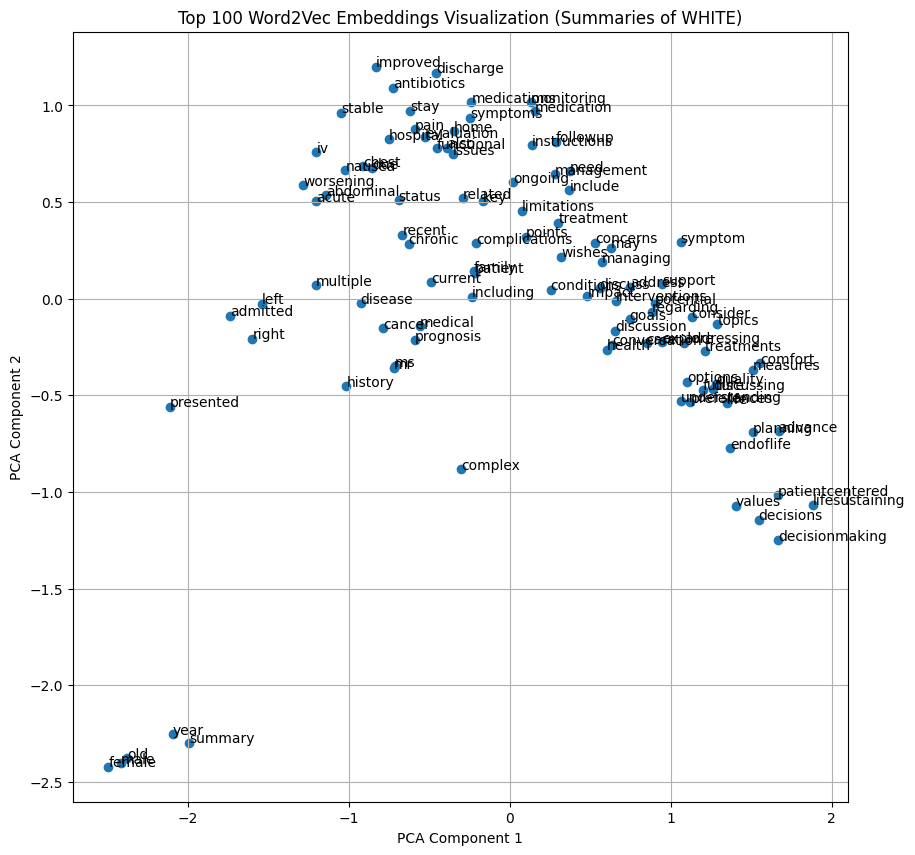

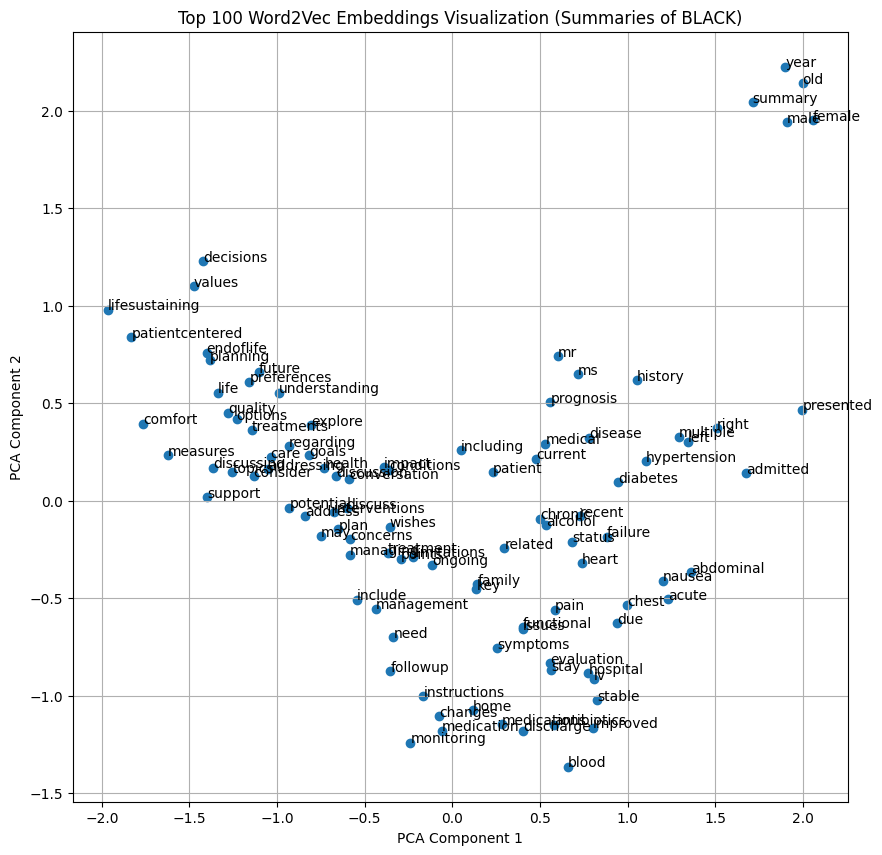

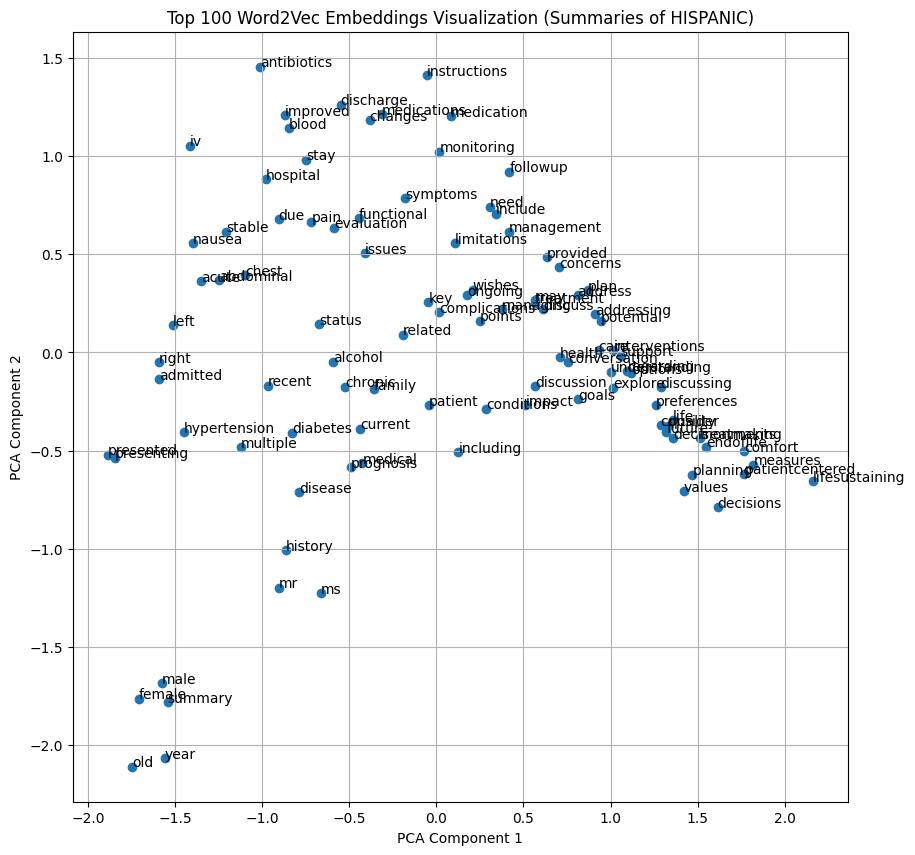

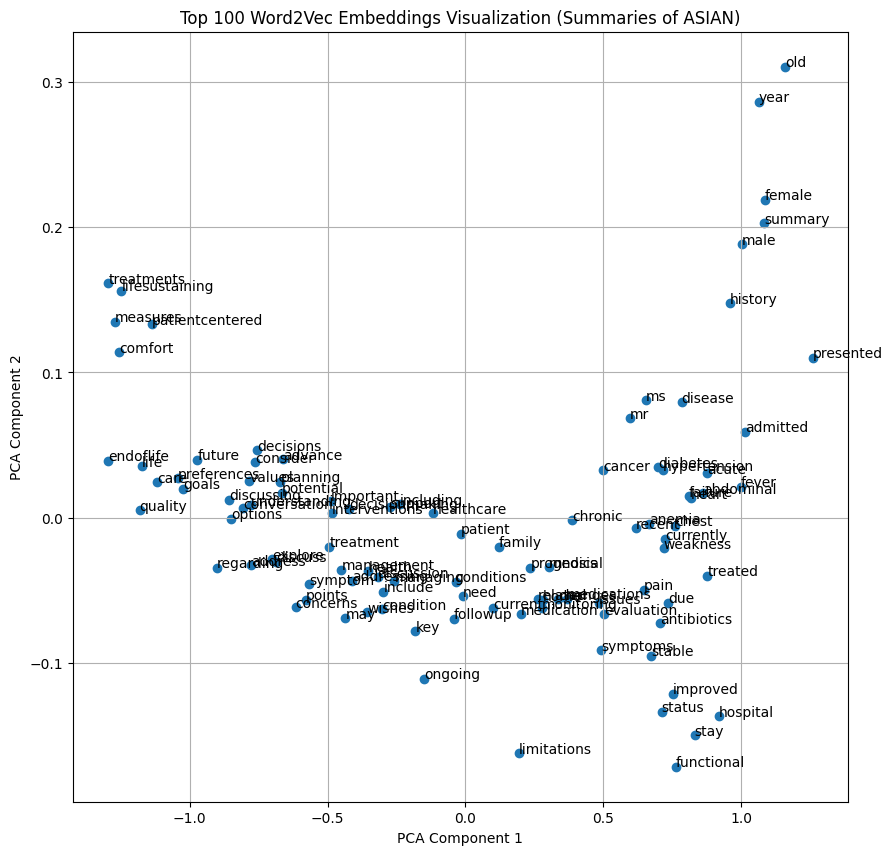

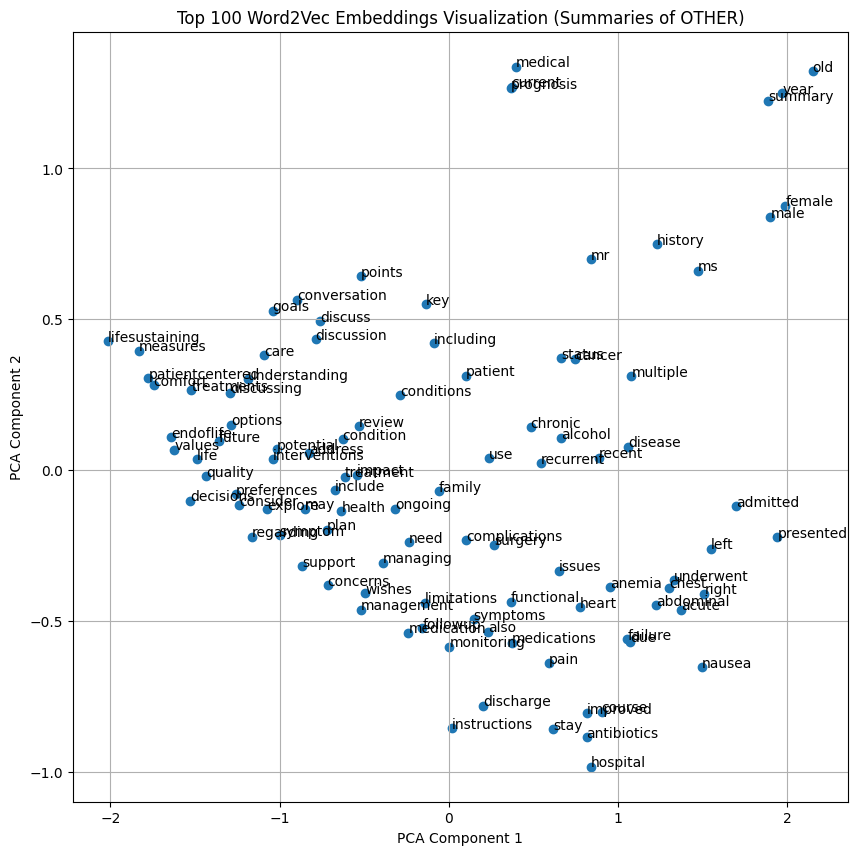

In [12]:
# Train Word2Vec model
for r in old_data['race'].unique():
  print(r)
  sentences = old_data[old_data['race'] == r]['text'].apply(clean_text).tolist()
  print(sentences[0][:30])
  print(len(sentences))
  try:
    model = Word2Vec.load(f'{r}.wordvectors')
  except:
    model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, sg=1, workers=4)
    model.save(f'{r}.wordvectors')

  # Count the frequency of words and get the top 100 most common
  word_counts = Counter(word for sentence in sentences for word in sentence)
  top_100_words = [word for word, _ in word_counts.most_common(100)]

  # Extract embeddings for the top 100 words
  embeddings = [model.wv[word] for word in top_100_words]

  # Reduce dimensionality for visualization using PCA
  pca = PCA(n_components=2)
  reduced_embeddings = pca.fit_transform(embeddings)

  # Plotting the word embeddings
  plt.figure(figsize=(10, 10))
  plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])

  for i, word in enumerate(top_100_words):
      plt.annotate(word, xy=(reduced_embeddings[i, 0], reduced_embeddings[i, 1]))

  plt.title(f'Top 100 Word2Vec Embeddings Visualization (Summaries of {r})')
  plt.xlabel('PCA Component 1')
  plt.ylabel('PCA Component 2')
  plt.grid()
  plt.savefig(f'{r}.png')